## Titanic's survival prediction

Predicting survival from one of the most well known shipwrecks in world history.


#### D2APR: Aprendizado de Máquina e Reconhecimento de Padrões (IFSP, Campinas)
**Prof**: Samuel Martins (Samuka)

**Study Project**
**Students**: Carlos Danilo Tomé e Lucas Galdino de Camargo

**Dataset**: https://www.kaggle.com/c/titanic/overview

## 1. Framing the Problem


#### 1.1 The Challenge
The sinking of the Titanic is one of the most infamous shipwrecks in history.

On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew.

While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.

In this challenge, we ask you to build a predictive model that answers the question: “what sorts of people were more likely to survive?” using passenger data (ie name, age, gender, socio-economic class, etc).


#### 1.2 What Data Will I Use in This Competition?
In this competition, you’ll gain access to two similar datasets that include passenger information like name, age, gender, socio-economic class, etc. One dataset is titled `train.csv` and the other is titled `test.csv`.

Train.csv will contain the details of a subset of the passengers on board (891 to be exact) and importantly, will reveal whether they survived or not, also known as the “ground truth”.

The `test.csv` dataset contains similar information but does not disclose the “ground truth” for each passenger. It’s your job to predict these outcomes.

Using the patterns you find in the train.csv data, predict whether the other 418 passengers on board (found in test.csv) survived.

Check out the “Data” tab to explore the datasets even further. Once you feel you’ve created a competitive model, submit it to Kaggle to see where your model stands on our leaderboard against other Kagglers.

#### 1.3 Goal
It is our job to predict if a passenger survived the sinking of the Titanic or not.
For each in the test set, we must predict a 0 or 1 value for the variable.

#### 1.4 Metric
The score for this competittion is the percentage of passengers we correctly predict. This is known as accuracy.


#### 1.5 Submission File Format
You should submit a csv file with exactly 418 entries plus a header row. Your submission will show an error if you have extra columns (beyond PassengerId and Survived) or rows.

The file should have exactly 2 columns:

    - PassengerId (sorted in any order)
    - Survived (contains your binary predictions: 1 for survived, 0 for deceased)
    
    
#### 1.6 Overview
The data has been split into two groups:

    - training set (train.csv)
    - test set (test.csv)
    
The training set should be used to build your machine learning models. For the training set, we provide the outcome (also known as the “ground truth”) for each passenger. Your model will be based on “features” like passengers’ gender and class. You can also use feature engineering to create new features.

The test set should be used to see how well your model performs on unseen data. For the test set, we do not provide the ground truth for each passenger. It is your job to predict these outcomes. For each passenger in the test set, use the model you trained to predict whether or not they survived the sinking of the Titanic.

We also include gender_submission.csv, a set of predictions that assume all and only female passengers survive, as an example of what a submission file should look like.


#### 1.7 Data Dictionary

| Variable | Definition | Key | 
|---|---|---|
| survival | Survival | 0 = No, 1 = Yes | 
| pclass | Ticket class | 1 = 1st, 2 = 2nd, 3 = 3rd |  
| sex | Sex |   |   
| Age | Age in years |  |
| sibsp | # of siblings / spouses aboard the Titanic |  |
| parch | # of parents / children aboard the Titanic |  |
| ticket | Ticket number |  |
| fare | Passenger fare |  |
| cabin | Cabin number | |
| embarked | Port of Embarkation | C = Cherbourg, Q = Queenstown, S = Southampton |


#### 1.8 Variable Notes

**pclass**: A proxy for socio-economic status (SES)
   - 1st = Upper
   - 2nd = Middle
   - 3rd = Lower

**age**: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

**sibsp**: The dataset defines family relations in this way...
   - Sibling = brother, sister, stepbrother, stepsister
   - Spouse = husband, wife (mistresses and fiancés were ignored)

**parch**: The dataset defines family relations in this way...
   - Parent = mother, father
   - Child = daughter, son, stepdaughter, stepson
   - Some children travelled only with a nanny, therefore parch=0 for them.

### 2. Imports

In [103]:
import pandas as pd
import numpy as np
import string
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mode
from pandas_profiling import ProfileReport
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, auc, log_loss
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin
import joblib

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

sns.set_theme(style="whitegrid")

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

# Reading the datasets
train = pd.read_csv('./datasets/train.csv')
submission_test = pd.read_csv('./datasets/test.csv')
gender_submission = pd.read_csv('./datasets/gender_submission.csv')

### 3. Exploratory Data Analysis

In [92]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [93]:
train.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

In [52]:
# Let's take a look at the survivalness rate
train['Survived'].value_counts(normalize=True)

0    0.616162
1    0.383838
Name: Survived, dtype: float64

#### 3.1 Checking for missing values

We have a lot of missing values for the attribute **Cabin**, so let's take a lot at that!
   - It seems that the Cabin attribute is strongly related either to Pclass (and consequently also related within the Fare paid) and to survivalness rate.
   - Maybe we could create a binary column considering if the person was in a Cabin or not.

Another attribute we've a lot of missings is the **Age**.
   - In order to deal with that, we'll guard some statistics about this dataset to replace these missing values latter.
   - As the social status and the Pclass are related within the Age, we'll use these 2 attributes to aggregate the mean age, and that's what we're using to do the missing replacements.
   
Finally, we also have missing values for the attribute **Embarked**.
   - That's not a big deal, once we have only 2 missing values.
   - We'll replace these missing values with the mode (most common value) of this attribute.

In [53]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [54]:
train[train['Cabin'].isnull() == False].describe()

PassengerId    Survived      Pclass         Age       SibSp  \
count   204.000000  204.000000  204.000000  185.000000  204.000000   
mean    455.401961    0.666667    1.196078   35.829297    0.441176   
std     251.379279    0.472564    0.525961   15.679356    0.628918   
min       2.000000    0.000000    1.000000    0.920000    0.000000   
25%     261.750000    0.000000    1.000000   24.000000    0.000000   
50%     457.500000    1.000000    1.000000   36.000000    0.000000   
75%     684.000000    1.000000    1.000000   48.000000    1.000000   
max     890.000000    1.000000    3.000000   80.000000    3.000000   

            Parch        Fare  
count  204.000000  204.000000  
mean     0.436275   76.141504  
std      0.729976   74.391749  
min      0.000000    0.000000  
25%      0.000000   29.453125  
50%      0.000000   55.220850  
75%      1.000000   89.328150  
max      4.000000  512.329200

In [55]:
train[train['Cabin'].isnull() == True].describe()

PassengerId    Survived      Pclass         Age       SibSp  \
count   687.000000  687.000000  687.000000  529.000000  687.000000   
mean    443.208151    0.299854    2.639010   27.555293    0.547307   
std     259.215905    0.458528    0.589602   13.472634    1.207492   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     214.500000    0.000000    2.000000   19.000000    0.000000   
50%     441.000000    0.000000    3.000000   26.000000    0.000000   
75%     664.500000    1.000000    3.000000   35.000000    1.000000   
max     891.000000    1.000000    3.000000   74.000000    8.000000   

            Parch        Fare  
count  687.000000  687.000000  
mean     0.365357   19.157325  
std      0.827106   28.663343  
min      0.000000    0.000000  
25%      0.000000    7.877100  
50%      0.000000   10.500000  
75%      0.000000   23.000000  
max      6.000000  512.329200

Let's take a look at the **Fare** attribute.

Well, we've 15 observations in the train set were the Fare is equal to zero.

This could be considered as missing values, but we won't replace them. 

In [56]:
train['Fare'].describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

In [57]:
train[train['Fare'] == 0]

PassengerId  Survived  Pclass                              Name   Sex  \
179          180         0       3               Leonard, Mr. Lionel  male   
263          264         0       1             Harrison, Mr. William  male   
271          272         1       3      Tornquist, Mr. William Henry  male   
277          278         0       2       Parkes, Mr. Francis "Frank"  male   
302          303         0       3   Johnson, Mr. William Cahoone Jr  male   
413          414         0       2    Cunningham, Mr. Alfred Fleming  male   
466          467         0       2             Campbell, Mr. William  male   
481          482         0       2  Frost, Mr. Anthony Wood "Archie"  male   
597          598         0       3               Johnson, Mr. Alfred  male   
633          634         0       1     Parr, Mr. William Henry Marsh  male   
674          675         0       2        Watson, Mr. Ennis Hastings  male   
732          733         0       2              Knight, Mr. Robert J  male   
806          807         0       1            Andrews, Mr. Thomas Jr  male   
815          816         0       1                  Fry, Mr. Richard  male   
822          823         0       1   Reuchlin, Jonkheer. John George  male   

      Age  SibSp  Parch  Ticket  Fare Cabin Embarked  
179  36.0      0      0    LINE   0.0   NaN        S  
263  40.0      0      0  112059   0.0   B94        S  
271  25.0      0      0    LINE   0.0   NaN        S  
277   NaN      0      0  239853   0.0   NaN        S  
302  19.0      0      0    LINE   0.0   NaN        S  
413   NaN      0      0  239853   0.0   NaN        S  
466   NaN      0      0  239853   0.0   NaN        S  
481   NaN      0      0  239854   0.0   NaN        S  
597  49.0      0      0    LINE   0.0   NaN        S  
633   NaN      0      0  112052   0.0   NaN        S  
674   NaN      0      0  239856   0.0   NaN        S  
732   NaN      0      0  239855   0.0   NaN        S  
806  39.0      0      0  112050   0.0   A36        S  
815   NaN      0      0  112058   0.0  B102        S  
822  38.0      0      0   19972   0.0   NaN        S

In [58]:
train[train['Fare'] != 0].describe()

PassengerId    Survived      Pclass         Age       SibSp  \
count   876.000000  876.000000  876.000000  707.000000  876.000000   
mean    444.794521    0.389269    2.315068   29.645219    0.531963   
std     257.806393    0.487863    0.835663   14.558872    1.110009   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     220.750000    0.000000    2.000000   20.000000    0.000000   
50%     444.500000    0.000000    3.000000   28.000000    0.000000   
75%     667.250000    1.000000    3.000000   38.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  876.000000  876.000000  
mean     0.388128   32.755650  
std      0.811374   49.936826  
min      0.000000    4.012500  
25%      0.000000    7.925000  
50%      0.000000   14.500000  
75%      0.000000   31.275000  
max      6.000000  512.329200

In [59]:
train[train['Fare'] == 0].describe()

PassengerId   Survived     Pclass        Age  SibSp  Parch  Fare
count    15.000000  15.000000  15.000000   7.000000   15.0   15.0  15.0
mean    516.400000   0.066667   1.933333  35.142857    0.0    0.0   0.0
std     225.808958   0.258199   0.798809  10.023781    0.0    0.0   0.0
min     180.000000   0.000000   1.000000  19.000000    0.0    0.0   0.0
25%     290.500000   0.000000   1.000000  30.500000    0.0    0.0   0.0
50%     482.000000   0.000000   2.000000  38.000000    0.0    0.0   0.0
75%     704.000000   0.000000   2.500000  39.500000    0.0    0.0   0.0
max     823.000000   1.000000   3.000000  49.000000    0.0    0.0   0.0

#### 3.2 Data Cleaning and creation of new features

In [60]:
# Getting the Lastname
names = train['Name'].str.split(",", n=1, expand = True)

train['lastname'] = names[0]
train['Name'] = names[1]

# Getting the person's status/title 
names = train['Name'].str.strip().str.split(".", n=1, expand = True)
train['status'] = names[0]
train.drop('Name',axis=1,inplace=True)

# Getting the size of the family on board
train['family_members'] = train['SibSp'] + train['Parch'] + 1

# Getting the ticket's fare unitary (per person)
train['unitary_fare'] = train['Fare']/train['family_members']

# Getting just the information about the Cabin Area
train['Cabin'] = train.Cabin.str.slice(0,1,1)

# Replacing NA Cabin values for U (Unknown)
train['Cabin'] = train.Cabin.fillna('U')

# Replacing NA Embarked values with the mode of Embarked attribute
train['Embarked'] = train.Embarked.fillna(mode(train['Embarked'])[0][0])

# Getting just the first element of the Ticket
train['Ticket'] = train.Ticket.str.slice(0,1,1)

train.head()

PassengerId  Survived  Pclass     Sex   Age  SibSp  Parch Ticket     Fare  \
0            1         0       3    male  22.0      1      0      A   7.2500   
1            2         1       1  female  38.0      1      0      P  71.2833   
2            3         1       3  female  26.0      0      0      S   7.9250   
3            4         1       1  female  35.0      1      0      1  53.1000   
4            5         0       3    male  35.0      0      0      3   8.0500   

  Cabin Embarked   lastname status  family_members  unitary_fare  
0     U        S     Braund     Mr               2       3.62500  
1     C        C    Cumings    Mrs               2      35.64165  
2     U        S  Heikkinen   Miss               1       7.92500  
3     C        S   Futrelle    Mrs               2      26.55000  
4     U        S      Allen     Mr               1       8.05000

In [61]:
status = train.groupby(['status']).apply(lambda x: pd.Series(dict(title_count = ((x.Survived.count()))
                                                                    ,survived = ((x.Survived.sum()))
                                                                    ,survival_perc = ((x.Survived.sum()*100/x.Survived.count()))
))).reset_index()

status.sort_values(by='survival_perc',ascending=False)

status  title_count  survived  survival_perc
16  the Countess          1.0       1.0     100.000000
9           Mlle          2.0       2.0     100.000000
15           Sir          1.0       1.0     100.000000
13            Ms          1.0       1.0     100.000000
5           Lady          1.0       1.0     100.000000
10           Mme          1.0       1.0     100.000000
12           Mrs        125.0      99.0      79.200000
8           Miss        182.0     127.0      69.780220
7         Master         40.0      23.0      57.500000
1            Col          2.0       1.0      50.000000
6          Major          2.0       1.0      50.000000
3             Dr          7.0       3.0      42.857143
11            Mr        517.0      81.0      15.667311
4       Jonkheer          1.0       0.0       0.000000
14           Rev          6.0       0.0       0.000000
2            Don          1.0       0.0       0.000000
0           Capt          1.0       0.0       0.000000

In [62]:
def resume_status(df):
    status = df['status']
    
    if df['Sex'] == 'male':
        if status in ['Master','Col','Major','Dr']:
            return 'Other'
        else:
            return 'Mr'
    else:     
        if status in ['Mlle', 'Ms', 'Miss']:
            return 'Miss'
        else:
            return 'Mrs'       

# applying the function to deal with the status
train['new_status']= train.apply(resume_status, axis=1)

# dropping columns we won't need anymore
train.drop(['lastname','status'],axis=1,inplace=True)

# Viewing some stats from the new_status 
status = train.groupby(['new_status']).apply(lambda x: pd.Series(dict(title_count = ((x.Survived.count()))
                                                                    ,survived = ((x.Survived.sum()))
                                                                    ,survival_perc = ((x.Survived.sum()*100/x.Survived.count()))
))).reset_index()

status.sort_values(by='survival_perc',ascending=False)

new_status  title_count  survived  survival_perc
2        Mrs        129.0     103.0      79.844961
0       Miss        185.0     130.0      70.270270
3      Other         50.0      27.0      54.000000
1         Mr        527.0      82.0      15.559772

In [63]:
# creating the dataframe we'll use to deal with mising values within the Age feature
age_info = train.groupby(['Pclass','new_status']).apply(lambda x: pd.Series(dict(persons_count = ((x.Survived.count()))
                                                                    ,survived = ((x.Survived.sum()))
                                                                    ,survival_perc = ((x.Survived.sum()*100/x.Survived.count()))
                                                                    ,mean_age = ((np.round(x.Age.mean(),0)))
                                                                    ,median_age = ((np.round(x.Age.median(),0)))
))).reset_index()

# age_info.to_csv('../working/age_info.csv', sep=';',index=False)
age_info.to_csv('./datasets/age_info.csv', sep=';',index=False)  
    
age_info.sort_values(by='survival_perc',ascending=False)

Pclass new_status  persons_count  survived  survival_perc  mean_age  \
2        1        Mrs           46.0      45.0      97.826087      41.0   
0        1       Miss           48.0      46.0      95.833333      30.0   
4        2       Miss           35.0      33.0      94.285714      23.0   
6        2        Mrs           41.0      37.0      90.243902      34.0   
7        2      Other           11.0       9.0      81.818182       9.0   
3        1      Other           11.0       7.0      63.636364      35.0   
8        3       Miss          102.0      51.0      50.000000      16.0   
10       3        Mrs           42.0      21.0      50.000000      34.0   
11       3      Other           28.0      11.0      39.285714       5.0   
1        1         Mr          111.0      38.0      34.234234      42.0   
9        3         Mr          319.0      36.0      11.285266      29.0   
5        2         Mr           97.0       8.0       8.247423      33.0   

    median_age  
2         42.0  
0         30.0  
4         24.0  
6         32.0  
7          2.0  
3         44.0  
8         18.0  
10        31.0  
11         4.0  
1         40.0  
9         26.0  
5         31.0

In [64]:
# Read the age info to substitute missing values
age_info = pd.read_csv('./datasets/age_info.csv',sep=';')
age = age_info[['Pclass','new_status','mean_age']].copy()

# left join to get mean_age
train = train.merge(age, how='left', on=['Pclass','new_status'])
# replacing null values for the mean_age giving the Pclass and new_status
train.Age = np.where(train.Age.isnull(), train.mean_age, train.Age) 

# Dropping mean_age, which we won't need anymore
train.drop('mean_age',axis=1,inplace=True) 

In [67]:
def age_solving(df):
       
    # Defining the age_class
    age = df['Age']
    
    if age <= 10:
        return 'child'
    elif age <= 18:
        return 'teen'
    elif age <= 60:
        return 'adult'
    else:     
        return 'senior'      

In [68]:
# Applying the function to deal with missing values in Age and create the age_class
train['age_class']= train.apply(age_solving, axis=1)

# Viewing some stats from the age_class created
age_class = train.groupby(['age_class']).apply(lambda x: pd.Series(dict(title_count = ((x.Survived.count()))
                                                                    ,survived = ((x.Survived.sum()))
                                                                    ,survival_perc = ((x.Survived.sum()*100/x.Survived.count()))
))).reset_index()

age_class.sort_values(by='survival_perc',ascending=False)

age_class  title_count  survived  survival_perc
1     child         68.0      40.0      58.823529
3      teen        108.0      51.0      47.222222
0     adult        693.0     246.0      35.497835
2    senior         22.0       5.0      22.727273

In [78]:
def fml_clss(df):
    # Defining the family_class
    family = df['family_members']
    
    if family == 1:
        return 'alone'
    elif family <= 4:
        return 'small family'
    else:     
        return 'big family'  

In [79]:
# Applying the function to create the family class
train['family_class']= train.apply(fml_clss, axis=1)

# Viewing some stats from the family_class created
family_class = train.groupby(['family_class']).apply(lambda x: pd.Series(dict(title_count = ((x.Survived.count()))
                                                                    ,survived = ((x.Survived.sum()))
                                                                    ,survival_perc = ((x.Survived.sum()*100/x.Survived.count()))
))).reset_index()

family_class.sort_values(by='survival_perc',ascending=False)

family_class  title_count  survived  survival_perc
2  small family        292.0     169.0      57.876712
0         alone        537.0     163.0      30.353818
1    big family         62.0      10.0      16.129032

In [69]:
sex = train.groupby(['Sex']).apply(lambda x: pd.Series(dict(count = ((x.Survived.count()))
                                                                    ,survived = ((x.Survived.sum()))
                                                                    ,survival_perc = ((x.Survived.sum()*100/x.Survived.count()))
))).reset_index()

sex.sort_values(by='survival_perc',ascending=False)

Sex  count  survived  survival_perc
0  female  314.0     233.0      74.203822
1    male  577.0     109.0      18.890815

In [70]:
cabin = train.groupby(['Cabin']).apply(lambda x: pd.Series(dict(count = ((x.Survived.count()))
                                                                    ,survived = ((x.Survived.sum()))
                                                                    ,survival_perc = ((x.Survived.sum()*100/x.Survived.count()))
))).reset_index()

cabin.sort_values(by='survival_perc',ascending=False)

Cabin  count  survived  survival_perc
3     D   33.0      25.0      75.757576
4     E   32.0      24.0      75.000000
1     B   47.0      35.0      74.468085
5     F   13.0       8.0      61.538462
2     C   59.0      35.0      59.322034
6     G    4.0       2.0      50.000000
0     A   15.0       7.0      46.666667
8     U  687.0     206.0      29.985444
7     T    1.0       0.0       0.000000

In [71]:
embarked = train.groupby(['Embarked']).apply(lambda x: pd.Series(dict(title_count = ((x.Survived.count()))
                                                                    ,survived = ((x.Survived.sum()))
                                                                    ,survival_perc = ((x.Survived.sum()*100/x.Survived.count()))
))).reset_index()

embarked.sort_values(by='survival_perc',ascending=False)

Embarked  title_count  survived  survival_perc
0        C        168.0      93.0      55.357143
1        Q         77.0      30.0      38.961039
2        S        646.0     219.0      33.900929

In [72]:
ticket = train.groupby(['Ticket']).apply(lambda x: pd.Series(dict(count = ((x.Survived.count()))
                                                                    ,survived = ((x.Survived.sum()))
                                                                    ,fare_mean = ((x.Fare.mean()))
                                                                    ,survival_perc = ((x.Survived.sum()*100/x.Survived.count()))
))).reset_index()

ticket.sort_values(by='count',ascending=False)

Ticket  count  survived   fare_mean  survival_perc
2       3  301.0      72.0   15.969611      23.920266
1       2  183.0      85.0   19.903349      46.448087
0       1  146.0      92.0   62.126797      63.013699
13      P   65.0      42.0  114.085831      64.615385
14      S   65.0      21.0   17.347822      32.307692
10      C   47.0      16.0   28.335462      34.042553
9       A   29.0       2.0    9.975286       6.896552
15      W   13.0       2.0   32.817308      15.384615
3       4   10.0       2.0   15.893770      20.000000
6       7    9.0       1.0    9.367133      11.111111
11      F    7.0       4.0   24.223214      57.142857
5       6    6.0       1.0   14.711817      16.666667
12      L    4.0       1.0    0.000000      25.000000
4       5    3.0       0.0   19.262500       0.000000
7       8    2.0       0.0    8.397900       0.000000
8       9    1.0       1.0    7.750000     100.000000

#### 3.3 Data visualization

In [77]:
train.head()

PassengerId  Survived  Pclass     Sex   Age  SibSp  Parch Ticket     Fare  \
0            1         0       3    male  22.0      1      0      A   7.2500   
1            2         1       1  female  38.0      1      0      P  71.2833   
2            3         1       3  female  26.0      0      0      S   7.9250   
3            4         1       1  female  35.0      1      0      1  53.1000   
4            5         0       3    male  35.0      0      0      3   8.0500   

  Cabin Embarked  family_members  unitary_fare new_status age_class  
0     U        S               2       3.62500         Mr     adult  
1     C        C               2      35.64165        Mrs     adult  
2     U        S               1       7.92500       Miss     adult  
3     C        S               2      26.55000        Mrs     adult  
4     U        S               1       8.05000         Mr     adult

Text(0.5, 1.0, 'Unitary Fare')

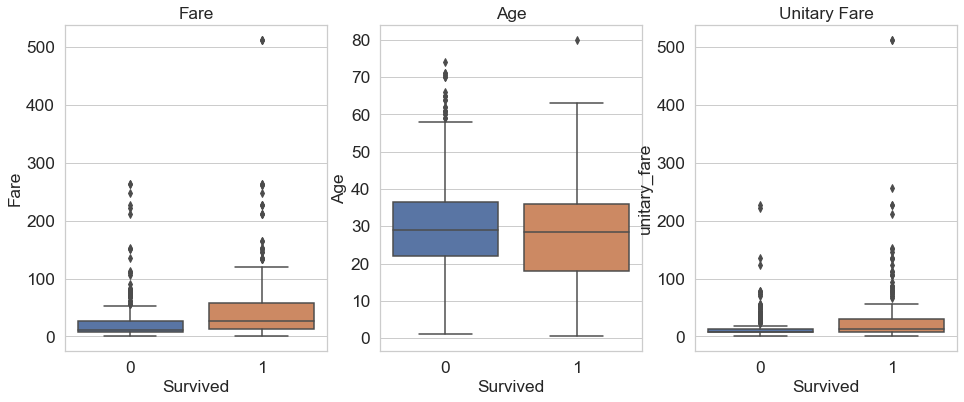

In [73]:
fig, axes = plt.subplots(1, 3, figsize=(16, 6))

sns.boxplot(data=train, y="Fare", x="Survived", ax=axes[0]).set(xlabel="Survived")
axes[0].set_title('Fare')

sns.boxplot(data=train, y="Age", x="Survived", ax=axes[1]).set(xlabel="Survived")
axes[1].set_title('Age')

sns.boxplot(data=train, y="unitary_fare", x="Survived", ax=axes[2]).set(xlabel="Survived")
axes[2].set_title('Unitary Fare')

Text(0.5, 1.0, "Family's size")

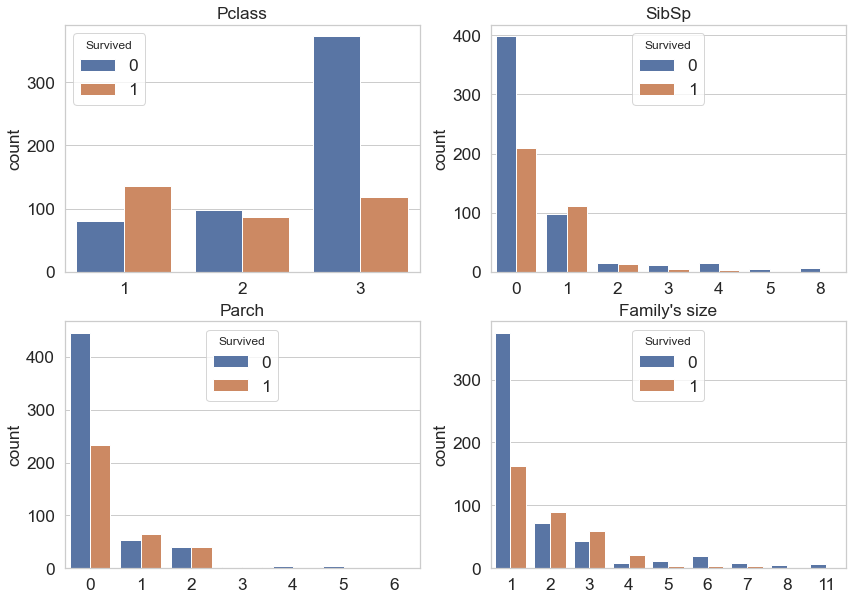

In [74]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

sns.countplot(x="Pclass", hue="Survived", data=train, ax=axes[0,0]).set(xlabel=None)
axes[0,0].set_title('Pclass')

sns.countplot(x="SibSp", hue="Survived", data=train, ax=axes[0,1]).set(xlabel=None)
axes[0,1].set_title('SibSp')

sns.countplot(x="Parch", hue="Survived", data=train, ax=axes[1,0]).set(xlabel=None)
axes[1,0].set_title('Parch')

sns.countplot(x="family_members", hue="Survived", data=train, ax=axes[1,1]).set(xlabel=None)
axes[1,1].set_title("Family's size")

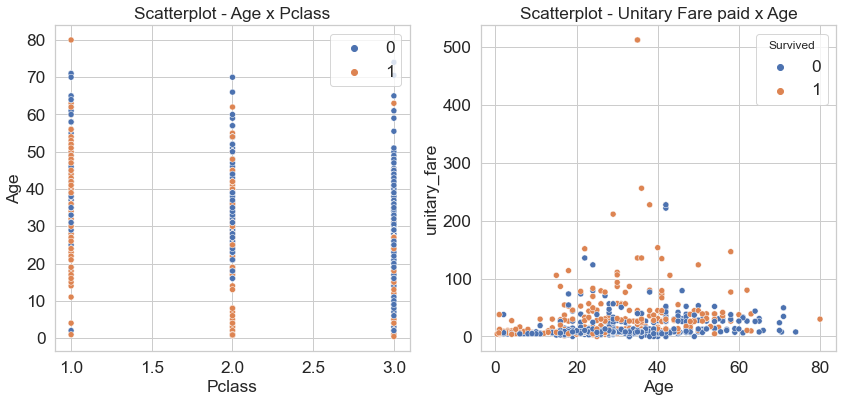

In [76]:
##### HUE of survivalness by Age x Pclass and unitary_fare x Age
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.scatterplot(y="Age", x='Pclass', data=train, hue ='Survived',  ax=axes[0], color = 'tab:blue').legend(loc='upper right')
axes[0].set_title('Scatterplot - Age x Pclass')

sns.scatterplot(y="unitary_fare", x='Age', data=train, hue ='Survived',  ax=axes[1], color = 'tab:orange')
axes[1].set_title('Scatterplot - Unitary Fare paid x Age');

#### 3.4 Profile Report

In [80]:
# profile = ProfileReport(train, title="Pandas Profiling Report - Titanic", explorative=True)
profile = ProfileReport(train, title="Pandas Profiling Report - Titanic")
profile

### 4. Modelling

In [155]:
class pre_processing_transform(BaseEstimator, TransformerMixin):
    
    # class that creates the new variables
    # class that deals with the outliers in the coordinates
    # class that substitutes the District by its created hierarchical class considering its mean price per square meter
    # Goal: customized transformator to consider in the pipeline as well as adapted to sklearn
    # notes: with this configuration this class is able to do "fit", "transform" and "fit_transform", natives on sklearn
    
    def __init__(self,age_sub='mean_age'):
        self.age_sub = age_sub
        return None
    
    def fit(self,X,y = None):
        return self
    
    def resume_status(df):
        # treating the status feature
        status = df['status']

        if df['Sex'] == 'male':
            if status in ['Master','Col','Major','Dr']:
                return 'Other'
            else:
                return 'Mr'
        else:     
            if status in ['Mlle', 'Ms', 'Miss']:
                return 'Miss'
            else:
                return 'Mrs'       

    def age_solving(df):
        # Defining the age_class
        age = df['Age']

        if age <= 10:
            return 'child'
        elif age <= 18:
            return 'teen'
        elif age <= 60:
            return 'adult'
        else:     
            return 'senior'          

    def fml_clss(df):
        # Defining the family_class
        family = df['family_members']

        if family == 1:
            return 'alone'
        elif family <= 4:
            return 'small family'
        else:     
            return 'big family' 

    def transform(self, X, y = None):
        df = X.copy()        

        # Getting the person's status/title 
        names = df['Name'].str.split(",", n=1, expand = True)
        df['Name'] = names[1]
        names = df['Name'].str.strip().str.split(".", n=1, expand = True)
        df['status'] = names[0]

        # applying the function to deal with the status
        df['new_status']= df.apply(resume_status, axis=1)

        # Read the age info to substitute missing values
        age_info = pd.read_csv('./datasets/age_info.csv',sep=';')
        age = age_info[['Pclass','new_status',self.age_sub]].copy()

        # left join to get mean_age
        df = df.merge(age, how='left', on=['Pclass','new_status'])
        # replacing null values for the mean_age giving the Pclass and new_status
        df.Age = np.where(df.Age.isnull(), df[self.age_sub], df.Age) 

        # Applying the function to deal with missing values in Age and create the age_class
        df['age_class']= df.apply(age_solving, axis=1)    

        # Getting the size of the family on board
        df['family_members'] = df['SibSp'] + df['Parch'] + 1

        # Getting the ticket's fare unitary (per person)
        df['unitary_fare'] = df['Fare']/df['family_members']

        # Applying the function to create the family class
        df['family_class']= df.apply(fml_clss, axis=1)    

        # Replacing NA Cabin values for U (Unknown)
        df['Cabin'] = df.Cabin.isnull()
        df['Cabin'] = df['Cabin'].replace([True,False],[1,0])

        # Replacing NA Embarked values with the mode of Embarked attribute
        df['Embarked'] = df.Embarked.fillna('S')  

        df['female'] = df['Sex'].replace(['male','female'],[0,1])
        
        # dropping columns we won't need anymore
        df.drop(['PassengerId','Name','status','mean_age','Ticket','Sex'],axis=1,inplace=True)    

        df = pd.get_dummies(data=df,columns=['Embarked','new_status','age_class','family_class'],drop_first=True)            
        
        print(df.dtypes)
        
        return df

In [156]:
# Reading the datasets
train = pd.read_csv('./datasets/train.csv')
submission_test = pd.read_csv('./datasets/test.csv')

# Splitting the data between train and test
train, test = train_test_split(train, test_size=0.2, stratify=train['Sex'], random_state=42)

# Saving the data after split
train.to_csv('./datasets/train_set.csv', sep=';',index=False)
test.to_csv('./datasets/test_set.csv', sep=';',index=False)

In [157]:
# Importing our Train set and splitting it into features (X_train) and target (y_train)

# Loading trainning data
train = pd.read_csv('./datasets/train_set.csv', sep=';')

X_train = train.drop(['Survived'], axis=1).copy()
y_train = train['Survived'].copy()

# Importing Test set and split it into features (X_train) and target (y_train)

# Loading testing data
test = pd.read_csv('./datasets/test_set.csv', sep=';')

X_test = test.drop(['Survived'], axis=1).copy()
y_test = test['Survived'].copy()

# Loading the data to submission
X_submission_test = pd.read_csv('./datasets/submission_test.csv', sep=';')

In [158]:
pipeline = Pipeline([
        
    #Data preprocessing
    ('Criando as colunas', pre_processing_transform()),
    # Scaling our data with StandardScaler
    ('escalonando', StandardScaler())
])

In [ ]:
pipeline2 = Pipeline([
        
    #Data preprocessing
    ('Criando as colunas', pre_processing_transform(age_sub='median_age')),
    # Scaling our data with StandardScaler
    ('escalonando', StandardScaler())
])

In [159]:
# Fit and Apply the Pipeline
X_train_transformed = pipeline.fit_transform(X_train)

Pclass                         int64
Age                          float64
SibSp                          int64
Parch                          int64
Fare                         float64
Cabin                          int64
family_members                 int64
unitary_fare                 float64
female                         int64
Embarked_Q                     uint8
Embarked_S                     uint8
new_status_Mr                  uint8
new_status_Mrs                 uint8
new_status_Other               uint8
age_class_child                uint8
age_class_senior               uint8
age_class_teen                 uint8
family_class_big family        uint8
family_class_small family      uint8
dtype: object


In [162]:
X_train_transformed.shape

(712, 19)

In [144]:
# Saving Pipeline
joblib.dump(pipeline, '../preprocessed_pipeline.pkl')

['../preprocessed_pipeline.pkl']

### 5. Results and Discussion